<a href="https://colab.research.google.com/github/e8606876/images/blob/main/CNN_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [ ]:
!python --version

import os

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image
from theano import config
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

Python 3.6.9


In [ ]:
# copied from DeepLearning_Tutorial
def resize_and_crop(img,target_width=224,target_height=224):
    width, height = img.size

    img_ratio = width / float(height)
    target_ratio = target_width / float(target_height)

    # 1) compare ratios and resize the larger side proportional to the target of the smaller side
    new_width, new_height = (target_width, target_height)

    if target_ratio > img_ratio:
        new_height = int(round(height * (target_width / float(width))))
    else:
        new_width = int(round(width * (target_height / float(height))))

    img_new = img.resize((new_width, new_height), Image.ANTIALIAS)

    # 2) crop to target size
    # offset to half of the remaining padding (one of them is 0)
    width_offset  = (new_width - target_width) / 2
    height_offset = (new_height - target_height) / 2

    # crop with offsets
    img_new = img_new.crop((width_offset, height_offset, width_offset+target_width, height_offset+target_height))
    #  The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
    return img_new

In [ ]:
!ls

sample_data  yalefaces	yalefaces.zip


In [ ]:
!curl -LJO https://github.com/e8606876/images/raw/main/yalefaces.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   134  100   134    0     0   2977      0 --:--:-- --:--:-- --:--:--  2977
100 6035k  100 6035k    0     0  19.2M      0 --:--:-- --:--:-- --:--:-- 19.2M


In [ ]:
!unzip -d . yalefaces.zip 

**Load the Images from Training Set**

In [ ]:
path = 'yalefaces/TrainImages'
files = glob.glob(os.path.join(path, '*.*'))
print("Found", len(files), "files")

Found 154 files


In [ ]:

images = []
image_names = []

for filename in files:
    image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=32,target_height=32)
        images.append(np.array(img_resized))

In [ ]:
images[1]

array([[242, 242, 242, ..., 255, 255, 255],
       [255, 254, 255, ..., 255, 255, 254],
       [248, 255, 255, ..., 255, 254, 253],
       ...,
       [198, 188,  61, ..., 236, 241, 250],
       [206,  62,   0, ..., 229, 241, 246],
       [155,  11,   9, ..., 204, 213, 222]], dtype=uint8)

subject14.happy


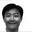

In [ ]:
# show a selected image to check
i=0
print(image_names[i])
Image.fromarray(images[i])

In [ ]:
# a list of many 32x32 images is made into 1 big array
img_array = np.array(images, dtype=config.floatX)
img_array.shape

(154, 32, 32)

**Create the Groundtruth based on filenames**

In [ ]:
classes = []
for name in image_names:
    if name.endswith('centerlight'):
        classes.append(1)
    if name.endswith('.glasses'):
        classes.append(2)
    if name.endswith('happy'):
        classes.append(3)
    if name.endswith('leftlight'):
        classes.append(4)
    if name.endswith('noglasses'):
        classes.append(5)
    if name.endswith('normal'):
        classes.append(6)
    if name.endswith('rightlight'):
        classes.append(7)
    if name.endswith('sad'):
        classes.append(8)
    if name.endswith('sleepy'):
        classes.append(9)
    if name.endswith('surprised'):
        classes.append(10)
    if name.endswith('wink'):
        classes.append(11)


In [ ]:
print(classes)

[3, 10, 5, 10, 8, 6, 4, 1, 5, 3, 9, 2, 1, 7, 10, 9, 2, 5, 7, 1, 1, 2, 6, 7, 1, 5, 7, 5, 11, 9, 11, 4, 11, 10, 9, 5, 7, 2, 9, 5, 8, 11, 10, 11, 7, 9, 2, 10, 2, 1, 5, 10, 6, 9, 1, 3, 4, 8, 6, 2, 7, 6, 7, 10, 3, 6, 9, 10, 2, 3, 4, 5, 7, 10, 4, 11, 11, 8, 8, 6, 7, 1, 5, 4, 4, 6, 3, 2, 10, 6, 8, 8, 8, 4, 7, 5, 8, 8, 6, 11, 3, 4, 7, 3, 4, 9, 3, 9, 4, 11, 11, 3, 9, 7, 5, 2, 1, 2, 3, 6, 1, 9, 10, 2, 3, 2, 8, 8, 4, 6, 10, 8, 10, 4, 11, 11, 6, 7, 1, 1, 2, 9, 5, 11, 3, 4, 5, 9, 1, 8, 1, 11, 6, 3]


In [ ]:
print("Groundtruth Statistics:")
for v in set(classes):
    print("Class", v, ":", classes.count(v))

baseline = 14 * 1.0 / len(classes)
print('baseline = ' + str(baseline))

Groundtruth Statistics:
Class 1 : 14
Class 2 : 14
Class 3 : 14
Class 4 : 14
Class 5 : 14
Class 6 : 14
Class 7 : 14
Class 8 : 14
Class 9 : 14
Class 10 : 14
Class 11 : 14
baseline = 0.09090909090909091


In [ ]:
classes = np.asarray(classes)

**Standardization**

In [ ]:
mean = img_array.mean()
stddev = img_array.std()
mean, stddev

(158.21215503246754, 94.77733358792085)

In [ ]:
img_array = (img_array - mean) / stddev
img_array.mean(), img_array.std()

(-5.0464682937507114e-17, 1.0)

In [ ]:
img_array.min(), img_array.max()

(-1.6693037147505414, 1.0212129979131197)

**Prepare test data**

In [ ]:
path = 'yalefaces/TestImages'
files = glob.glob(os.path.join(path, '*.*'))
print("Found", len(files), "files")

Found 11 files


In [ ]:
test_images = []
test_image_names = []

for filename in files:
    test_image_names.append(os.path.basename(filename))
    with Image.open(filename) as img:
        img_resized = resize_and_crop(img,target_width=32,target_height=32)
        test_images.append(np.array(img_resized))

subject01.leftlight


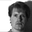

In [ ]:
i=2
print(test_image_names[i])
Image.fromarray(test_images[i])

In [ ]:
# a list of many 243x320 images is made into 1 big array
test_images = np.array(test_images)
test_images.shape

(11, 32, 32)

In [ ]:
test_classes = []
for name in test_image_names:
    if name.endswith('centerlight'):
        test_classes.append(1)
    if name.endswith('.glasses'):
        test_classes.append(2)
    if name.endswith('happy'):
        test_classes.append(3)
    if name.endswith('leftlight'):
        test_classes.append(4)
    if name.endswith('noglasses'):
        test_classes.append(5)
    if name.endswith('normal'):
        test_classes.append(6)
    if name.endswith('rightlight'):
        test_classes.append(7)
    if name.endswith('sad'):
        test_classes.append(8)
    if name.endswith('sleepy'):
        test_classes.append(9)
    if name.endswith('surprised'):
        test_classes.append(10)
    if name.endswith('wink'):
        test_classes.append(11)

In [ ]:
test_classes = np.asarray(test_classes)
print(test_classes)

[ 7  3  4  2  6 11 10  1  5  8  9]


In [ ]:
test_images.mean(), test_images.std()

(169.59011008522728, 81.84364127645134)

In [ ]:
test_images = (test_images - mean) / stddev

In [ ]:
test_images.mean(), test_images.std()

(0.12004932637406279, 0.8635360183511441)

# Creating NN Models in Keras

In [ ]:
n_channels = 1 # for grey-scale, 3 for RGB, but usually already present in the data

### JG: if keras.backend.image_dim_ordering() == 'th':
if keras.backend.image_data_format == 'th':
    
    # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
    train_img = img_array.reshape(img_array.shape[0], n_channels, img_array.shape[1], img_array.shape[2])
    test_img = test_images.reshape(test_images.shape[0], n_channels, test_images.shape[1], test_images.shape[2])
else:
    # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
    train_img = img_array.reshape(img_array.shape[0], img_array.shape[1], img_array.shape[2], n_channels)
    test_img = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], n_channels)

In [ ]:
print(img_array.shape)
print(train_img.shape)
print(test_images.shape)
print(test_img.shape)

(154, 32, 32)
(154, 32, 32, 1)
(11, 32, 32)
(11, 32, 32, 1)


In [ ]:
def build_lenet(width, height, depth, classes):
    # Initialize the model
    model = Sequential()

    # The first set of CONV => RELU => POOL layers
    model.add(Convolution2D(20, (5, 5), padding="same",
                     input_shape=(height, width, depth)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # The second set of CONV => RELU => POOL layers
    model.add(Convolution2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # The set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # The softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # Return the constructed network architecture
    return model

In [ ]:
model = build_lenet(32, 32, 1, 12)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 20)        520       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 50)        25050     
_________________________________________________________________
activation_13 (Activation)   (None, 16, 16, 50)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)             

In [ ]:
opt = 'sgd'
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt, metrics=["accuracy"])

In [ ]:
# TRAINING the model
history = model.fit(train_img, classes,
                       batch_size=32,
                       epochs=30,
                       validation_data=(test_img, test_classes),
                       verbose=1)

Epoch 1/30
5/5 [==============================] - 1s 122ms/step - loss: 2.4879 - accuracy: 0.0919 - val_loss: 2.4500 - val_accuracy: 0.0909
Epoch 2/30
5/5 [==============================] - 0s 76ms/step - loss: 2.4616 - accuracy: 0.1266 - val_loss: 2.4234 - val_accuracy: 0.2727
Epoch 3/30
5/5 [==============================] - 0s 76ms/step - loss: 2.4329 - accuracy: 0.1583 - val_loss: 2.4023 - val_accuracy: 0.2727
Epoch 4/30
5/5 [==============================] - 0s 77ms/step - loss: 2.4071 - accuracy: 0.2116 - val_loss: 2.3833 - val_accuracy: 0.2727
Epoch 5/30
5/5 [==============================] - 0s 79ms/step - loss: 2.3906 - accuracy: 0.2789 - val_loss: 2.3629 - val_accuracy: 0.2727
Epoch 6/30
5/5 [==============================] - 0s 78ms/step - loss: 2.3774 - accuracy: 0.2416 - val_loss: 2.3401 - val_accuracy: 0.2727
Epoch 7/30
5/5 [==============================] - 0s 77ms/step - loss: 2.3480 - accuracy: 0.2411 - val_loss: 2.3180 - val_accuracy: 0.2727
Epoch 8/30
5/5 [==========

**Visualization**

In [ ]:
def graph_training_history(history):
    plt.figure(1, constrained_layout=True)

    # summarize history for accuracy

    #plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')


    plt.show()
    # summarize history for loss

    #plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

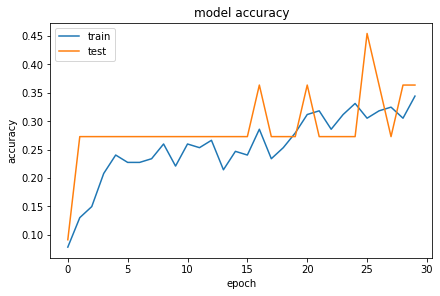

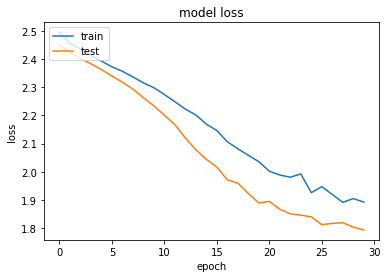

In [ ]:
# Visualize the training history
graph_training_history(history)

# New section